In [8]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

import gym
from gym_utils_q_learning import AtariEnv
from gym_utils_q_learning import AtariFrame
from AtariCNNModel import AtariModel
import numpy as np
import random

environment_name = "SpaceInvaders-v4"

# environment_name = "Pong-v4"
# typical_bad_game_frame_count = 1100
# reward_frame_shift = -1

action_count = gym.make(environment_name).action_space.n

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
#play a quick game to test out gym_utils

atari_env = AtariEnv(environment_name)
model = AtariModel(action_count)
model = model.cuda()
action = atari_env.env.action_space.sample()
    
for i in range(4000):
    atari_frame = atari_env.step(action)
    if atari_frame is None:
        break
    processed_frames = atari_frame.get_next_processed_frames()
    #print("processed_frames.shape: {}".format(processed_frames.shape))
    processed_frames = np.reshape(processed_frames, (1,)+processed_frames.shape)
    #print("processed_frames.shape: {}".format(processed_frames.shape))
    img_tensor = torch.from_numpy(processed_frames).float().cuda()
    
    output = model(img_tensor)
    
    action_array = output.detach().cpu().numpy()[0]
    print("model_actions: {}".format(action_array))
    action = np.argmax(action_array)
    
atari_env.close()

model_actions: [-0.02120054  0.02244951  0.03988355  0.03635981  0.01148808 -0.01525354]
model_actions: [-0.02123292  0.02242235  0.03988488  0.03627879  0.01149809 -0.01531308]
model_actions: [-0.02123485  0.02242506  0.03993276  0.03628152  0.01154002 -0.01532869]
model_actions: [-0.02112724  0.02241388  0.03988827  0.03627959  0.01151306 -0.01529802]
model_actions: [-0.02123349  0.02245701  0.03980234  0.03632244  0.01150433 -0.01529648]
model_actions: [-0.02123292  0.02242235  0.03988488  0.03627879  0.01149809 -0.01531308]
model_actions: [-0.02117664  0.02246775  0.03999854  0.0363237   0.01155792 -0.01531615]
model_actions: [-0.02123349  0.02245701  0.03980234  0.03632244  0.01150433 -0.01529648]
model_actions: [-0.02117664  0.02246775  0.03999854  0.0363237   0.01155792 -0.01531615]
model_actions: [-0.02120054  0.02244951  0.03988355  0.03635981  0.01148808 -0.01525354]
model_actions: [-0.02121267  0.02248877  0.03985947  0.03631161  0.01152087 -0.01534423]
model_actions: [-0.02

model_actions: [-0.02105581  0.02371594  0.04073107  0.03617219  0.01268805 -0.01639261]
model_actions: [-0.02106703  0.02368412  0.04076666  0.03616533  0.01270382 -0.01643822]
model_actions: [-0.021081    0.02367139  0.04068769  0.03622778  0.01272913 -0.01641082]
model_actions: [-0.02113767  0.02374402  0.04077404  0.03621764  0.01271578 -0.01638876]
model_actions: [-0.02110262  0.02372828  0.04077755  0.03615038  0.01269198 -0.01644592]
model_actions: [-0.02110315  0.02363959  0.04073225  0.03623945  0.01272346 -0.01647427]
model_actions: [-0.021081    0.02367139  0.04068769  0.03622778  0.01272913 -0.01641082]
model_actions: [-0.02106703  0.02368412  0.04076666  0.03616533  0.01270382 -0.01643822]


len(atari_env.frame_buffer): 126
processed_frames.shape: (4, 210, 160)
sample_frame.frame_index: 17
sample_frame.reward_list: [0.0, 0.0, 0.0, 0.0]


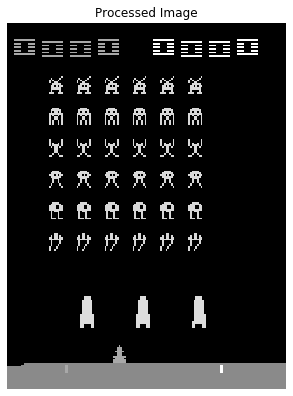

In [11]:
print("len(atari_env.frame_buffer): {}".format(len(atari_env.frame_buffer)))
atariFrame = atari_env.frame_buffer[17]
processed_frames = atariFrame.get_processed_frames()
print("processed_frames.shape: {}".format(processed_frames.shape))
print("sample_frame.frame_index: {}".format(atariFrame.frame_index))
print("sample_frame.reward_list: {}".format(atariFrame.reward_list))
atariFrame.show_processed_frame()


In [12]:
score = 0
for i, sample_frame in enumerate(atari_env.frame_buffer):
    score += np.sum(sample_frame.reward_list)
    print("frame_buffer[{}].reward_list: {} score: {}".format(i, sample_frame.reward_list, score))

frame_buffer[0].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[1].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[2].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[3].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[4].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[5].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[6].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[7].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[8].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[9].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[10].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[11].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[12].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[13].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[14].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[15].reward_list: [0.0, 0.0, 0.0, 0.0] score: 0.0
frame_buffer[16].r

In [13]:
#play a game. feed each frame into the model and see what we get
def play_game(atari_env, model, epsilon, max_frames=5000):
    model.eval()
    current_action = 0
    done = False
    frame_counter = 0
    
    while not done:
        atari_frame = atari_env.step(current_action)

        if atari_frame is None:  #processed_frames == None
            done = True
            continue
            
        processed_frames = atari_frame.get_processed_frames()

        processed_frames_batch = np.reshape(processed_frames, (1,)+processed_frames.shape)
        img_tensor = torch.from_numpy(processed_frames_batch).float().cuda()
        output = model(img_tensor)
        action_array = output.detach().cpu().numpy()[0]
    
        rand = random.uniform(0, 1)
        if rand < epsilon:
            current_action = atari_env.env.action_space.sample()
        else:
            current_action = np.argmax(action_array)

        frame_counter += 1
        if frame_counter > max_frames:
            break

def get_train_batch(atari_env, batch_size):
    rand_arr = np.arange(len(atari_env.frame_buffer))
    np.random.shuffle(rand_arr)
   
    index_counter = 0
    batch_index_counter = 0
    
    frame_batch = np.zeros((batch_size, 4, 210, 160))
    next_frame_batch = np.zeros((batch_size, 4, 210, 160))
    reward_batch = np.zeros(batch_size)
    actions_batch = np.zeros(batch_size)
    frame_number_batch = np.zeros(batch_size)
    
    for batch_index in range(batch_size):
        frame_number = rand_arr[batch_index]
        atari_frame = atari_env.frame_buffer[frame_number]
        
        frame_batch[batch_index] = atari_frame.get_processed_frames()
        next_frame_batch[batch_index] = atari_frame.get_next_processed_frames()
        reward_batch[batch_index] = atari_frame.getReward()
        actions_batch[batch_index] = atari_frame.action_taken
        frame_number_batch[batch_index] = frame_number

    return frame_batch, next_frame_batch, actions_batch, reward_batch, frame_number_batch
    

def train(atari_env, model, optimizer, criterion):
    train_batch_size = 50
    model.train()
    hidden = model.init_hidden(train_batch_size)
    #print("init hidden[0] shape: {}".format(hidden[0].shape))
    action_count = atari_env.env.action_space.n
    discounted_rewards = atari_env.get_discounted_rewards()
    frame_buffer = atari_env.frame_buffer
    action_tally = np.zeros(action_count)
    train_tally = np.zeros(action_count)
    
    total_loss = 0
    epochs = 25
    #for ii, reward_ii in enumerate(discounted_rewards):
    for i in range(epochs):
    
        #print("{}: {}".format(i, reward))
        optimizer.zero_grad()
        hidden = tuple([each.data for each in hidden])
        frame_batch, target_batch, reward_batch, actions_batch = get_train_batch(atari_env, train_batch_size)
        #print("get_train_batch. frame_batch: {}, target_batch: {}, reward_batch: {}".format(frame_batch.shape, target_batch.shape, reward_batch.shape))
        
        #reward_batch = reward_batch + reward_mean_shift #shift rewards for long games
        
        #print("train frame batch shape: {}".format(frame_batch.shape))
        img_tensor = torch.from_numpy(frame_batch).float().cuda()
        output, hidden = model(img_tensor, hidden)

        target = torch.from_numpy(target_batch)
        #print("training target: {}".format(target))
        target = target.long().cuda()
        #print("output: {}, target: {}".format(output.shape, target))
        
        loss = criterion(output, target)
        #print("loss: {}".format(loss))
        total_loss += loss
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
    
    print("avg loss: {:.3f}".format(total_loss / epochs))
#    print("model action_tally: {}".format(action_tally))
#    print("train_tally:        {}".format(train_tally))


In [36]:
atari_model = AtariModel(action_count)
atari_model.cuda()
gamma = .98
atari_optimizer = optim.Adam(atari_model.parameters(), lr=0.00001)


In [40]:

atari_env = AtariEnv(environment_name)
play_game(atari_env, atari_model, 0.5, max_frames=2000)
    
atari_env.close()

batch_size = 64
frame_batch, next_frame_batch, actions_batch, reward_batch, frame_number_batch = get_train_batch(atari_env, batch_size)

# print(frame_batch.shape)
# print(next_frame_batch.shape)
# print(actions_batch)
# print(reward_batch)
# print(frame_number_batch)


# target_q_values_next = self.qnetwork_target(next_states)
img_tensor = torch.from_numpy(next_frame_batch).float().cuda()
target_q_values_next = atari_model(img_tensor)
# print("target_q_values_next:")
# print(target_q_values_next[:10])
target_q_values_next_max, indices = torch.max(target_q_values_next, dim=1, keepdim=True)
# print("target_q_values_next_max: {}".format(target_q_values_next_max[:10]))
# print("indices: {}".format(indices[:10]))

# target_q_values_next_max = target_q_values_next_max * (1 - dones)  #remove dones

# local_q_values = self.qnetwork_local(states)
img_tensor_next = torch.from_numpy(frame_batch).float().cuda()
local_q_values = atari_model(img_tensor_next)

print("local_q_values:")
print(local_q_values[:10])

actions_batch_reshaped = np.reshape(actions_batch, (64, 1))
actions_batch_tensor = torch.from_numpy(actions_batch_reshaped).long().cuda()
#print("actions_batch_tensor.shape: {}".format(actions_batch_tensor.shape))
#print("local_q_values.shape: {}".format(local_q_values.shape))

local_q_values_performed = local_q_values.gather(1, actions_batch_tensor)
#print("local_q_values_performed: {}".format(local_q_values_performed))

reward_batch_reshaped = np.reshape(reward_batch, (64, 1))
reward_batch_tensor = torch.from_numpy(reward_batch_reshaped).float().cuda()

# print("reward_batch_tensor.shape: {}".format(reward_batch_tensor.shape))
# print("target_q_values_next_max.shape: {}".format(target_q_values_next_max.shape))
# print("local_q_values_performed.shape: {}".format(local_q_values_performed.shape))

# print("reward_batch_tensor[:10]: {}".format(reward_batch_tensor[:10]))
# print("target_q_values_next_max[:10]: {}".format(target_q_values_next_max[:10]))
# print("local_q_values_performed[:10]: {}".format(local_q_values_performed[:10]))

loss = torch.mean((reward_batch_tensor + (gamma * target_q_values_next_max) - local_q_values_performed)**2)
print("loss: {}".format(loss))

atari_optimizer.zero_grad()
loss.backward()
atari_optimizer.step()




local_q_values:
tensor([[-3.2877e-02, -2.1703e-03,  6.3530e-04, -2.2372e-02, -3.4249e-02,
         -4.7998e-03],
        [-3.2654e-02, -4.8813e-04, -3.2965e-04, -2.0332e-02, -3.3319e-02,
         -5.9629e-03],
        [-3.3156e-02, -1.6774e-03,  2.4785e-04, -2.1721e-02, -3.4389e-02,
         -4.4157e-03],
        [-3.2834e-02, -1.5024e-03, -6.5897e-04, -2.1737e-02, -3.3290e-02,
         -5.3344e-03],
        [-3.3051e-02, -6.7050e-04, -9.5817e-05, -2.1086e-02, -3.5439e-02,
         -4.8082e-03],
        [-3.3023e-02, -7.8036e-04,  3.2398e-04, -2.0702e-02, -3.2910e-02,
         -5.9152e-03],
        [-3.2595e-02, -1.5203e-03, -4.0230e-04, -2.0604e-02, -3.2948e-02,
         -5.4507e-03],
        [-3.3314e-02, -1.6173e-03,  1.1618e-03, -2.0917e-02, -3.2465e-02,
         -5.5994e-03],
        [-3.2874e-02, -6.5647e-04,  1.0685e-03, -2.1460e-02, -3.3439e-02,
         -5.3598e-03],
        [-3.2761e-02, -1.6293e-03, -4.0014e-04, -2.1669e-02, -3.3457e-02,
         -5.2925e-03]], device='cuda:

In [10]:
### optimizer
atari_optimizer = optim.Adam(atari_model.parameters(), lr=0.00001)

for i in range(11):
    #play a game
    use_probability_based_action = i % 5 != 0 or i == 0
    atari_env, hidden = play_game(environment_name, atari_model, use_probability_based_action)

    #discounted_rewards = atari_env.get_discounted_rewards()
    #print()
    #print(discounted_rewards)
    print("\n{}) frames played: {}, score: {}".format(i, len(atari_env.frame_buffer), atari_env.get_total_score()))
    print("actions taken: {}".format(atari_env.get_actions_taken()))

    #train the model
    train(atari_env, atari_model, atari_optimizer, atari_criterion)



0) frames played: 333, score: 60.0
actions taken: [77. 59. 50. 44. 52. 51.]
avg loss: 1.691

1) frames played: 623, score: 80.0
actions taken: [147.  97. 115.  90.  82.  92.]
avg loss: 1.790

2) frames played: 520, score: 110.0
actions taken: [121.  97.  79.  75.  72.  76.]
avg loss: 1.770

3) frames played: 915, score: 240.0
actions taken: [237. 142. 139. 134. 128. 135.]
avg loss: 1.700

4) frames played: 451, score: 60.0
actions taken: [110.  59.  80.  85.  58.  59.]
avg loss: 1.819

5) frames played: 928, score: 0.0
actions taken: [928.   0.   0.   0.   0.   0.]
no points granted. Setting all discounted rewards to -1
avg loss: 1.873

6) frames played: 1509, score: 260.0
actions taken: [255. 235. 256. 266. 251. 246.]
avg loss: 1.750

7) frames played: 588, score: 55.0
actions taken: [ 91. 117.  99.  86.  95. 100.]
avg loss: 1.791

8) frames played: 730, score: 340.0
actions taken: [111. 150. 123. 139. 103. 104.]
avg loss: 1.799

9) frames played: 802, score: 215.0
actions taken: [11

In [109]:
#display frame
frame_num=200
discounted_rewards = atari_env.get_discounted_rewards()

print("discounted_rewards mean: {}".format(np.mean(discounted_rewards)))


discounted_rewards mean: 1.7653235671058389e-16


frame: 746, original reward: -0.736
actions out: [0.15476361 0.2321394  0.15327428 0.15327428 0.15327428 0.15327428]


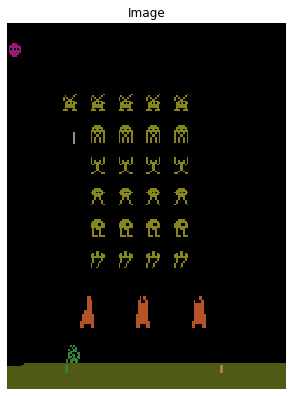

In [335]:
frame_num += 5
atari_frame = atari_env.frame_buffer[frame_num]

print("frame: {}, original reward: {:.3f}".format(frame_num, discounted_rewards[frame_num]))
print("actions out: {}".format(atari_env.frame_buffer[frame_num].action_array))

atari_frame.show_frame()

In [336]:
for i  in range(len(atari_env.frame_buffer)):
    print("actions out: {}".format(atari_env.frame_buffer[i].action_array))
    

actions out: [0.15588602 0.22110881 0.15575126 0.15575126 0.15575126 0.15575126]
actions out: [0.15462956 0.22797991 0.15434763 0.15434763 0.15434763 0.15434763]
actions out: [0.15447046 0.22875819 0.15419285 0.15419285 0.15419285 0.15419285]
actions out: [0.15444773 0.22884399 0.15417704 0.15417704 0.15417704 0.15417704]
actions out: [0.15443808 0.22885025 0.15417792 0.15417792 0.15417792 0.15417792]
actions out: [0.15442586 0.22884601 0.154182   0.154182   0.154182   0.154182  ]
actions out: [0.15441054 0.22883914 0.15418757 0.15418757 0.15418757 0.15418757]
actions out: [0.15439472 0.22883093 0.15419357 0.15419357 0.15419357 0.15419357]
actions out: [0.15438259 0.22882289 0.1541986  0.1541986  0.1541986  0.1541986 ]
actions out: [0.15437426 0.22881728 0.15420213 0.15420213 0.15420213 0.15420213]
actions out: [0.15436617 0.22881143 0.1542056  0.1542056  0.1542056  0.1542056 ]
actions out: [0.15435538 0.22880319 0.15421034 0.15421034 0.15421034 0.15421034]
actions out: [0.15434457 0.2

In [9]:
frame_batch, target_batch, reward_batch, actions_batch = get_train_batch(atari_env, 50)

target_tally = np.zeros(6)

for i  in range(len(reward_batch)):
    print("reward: {:.4f}, target: {}".format(reward_batch[i], target_batch[i]))
    target_tally[int(target_batch[i])] += 1
    
print(target_tally)

reward: -0.8604, target: 3.0
reward: 1.3911, target: 4.0
reward: -1.1576, target: 3.0
reward: -0.0128, target: 3.0
reward: -0.4280, target: 3.0
reward: -0.4917, target: 3.0
reward: -0.8007, target: 3.0
reward: -1.0440, target: 3.0
reward: -0.7486, target: 3.0
reward: 0.5455, target: 4.0
reward: -0.7897, target: 3.0
reward: 0.6045, target: 4.0
reward: -0.6514, target: 3.0
reward: -1.1364, target: 3.0
reward: 0.8160, target: 4.0
reward: 0.3267, target: 4.0
reward: 0.5948, target: 4.0
reward: -1.1296, target: 3.0
reward: 1.0987, target: 4.0
reward: -0.2401, target: 3.0
reward: -0.1402, target: 3.0
reward: -0.9419, target: 3.0
reward: -0.3903, target: 3.0
reward: -1.0405, target: 3.0
reward: -1.1576, target: 3.0
reward: -0.9636, target: 3.0
reward: 1.4699, target: 4.0
reward: -0.2732, target: 3.0
reward: 2.4107, target: 4.0
reward: 0.1405, target: 3.0
reward: -0.1791, target: 3.0
reward: 0.3095, target: 4.0
reward: -0.3093, target: 3.0
reward: 0.2978, target: 4.0
reward: 0.9062, target: 4.

In [338]:
train_batch_size = 50
frame_batch, target_batch, reward_batch, actions_batch = get_train_batch(atari_env, train_batch_size)

print("frame_batch.shape: {}".format(frame_batch.shape))
print("target_batch.shape: {}".format(target_batch.shape))
print("reward_batch.shape: {}".format(reward_batch.shape))
print("actions_batch.shape: {}".format(actions_batch.shape))

for i in range(50):
    #if i % 5 == 0:
    print()
    print("{}, target: {}".format(i, target_batch[i]))
    print("{}, reward: {}".format(i, reward_batch[i]))
    print("{}, action: {}".format(i, actions_batch[i]))
    


frame_batch.shape: (250, 3, 160, 210)
target_batch.shape: (50,)
reward_batch.shape: (50,)
actions_batch.shape: (50, 6)

0, target: 0.0
0, reward: -0.8018390070591428
0, action: [0.15444998 0.22775003 0.15444998 0.15444998 0.15444998 0.15444998]

1, target: 0.0
1, reward: -0.8017034540320515
1, action: [0.15445133 0.22774352 0.15445133 0.15445133 0.15445133 0.15445133]

2, target: 1.0
2, reward: 1.5765039649022463
2, action: [0.15392543 0.23037271 0.15392543 0.15392543 0.15392543 0.15392543]

3, target: 1.0
3, reward: 1.2217513083646452
3, action: [0.15409462 0.23164272 0.15356569 0.15356569 0.15356569 0.15356569]

4, target: 0.0
4, reward: -0.020593699973337345
4, action: [0.15429854 0.22850735 0.15429854 0.15429854 0.15429854 0.15429854]

5, target: 1.0
5, reward: 0.9509741523593829
5, action: [0.15441719 0.22791409 0.15441719 0.15441719 0.15441719 0.15441719]

6, target: 2.0
6, reward: -0.6277060183070393
6, action: [0.15454188 0.232397   0.15326527 0.15326527 0.15326527 0.15326527]
